# Proyecto de Ciencia de Datos - Análisis de Imágenes

Miembros del grupo:
- Mario Ruiz Vaquett
- Javier Pérez Vargas

## 0. Importación de librerías

Importamos las librerías que vamos a necesitar durante el cuaderno.

In [41]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Conjunto de Datos

Para almacenar el dataset, utilizaremos la clase **Dataset** de PyTorch, que nos permite definir cómo cargar, transformar y acceder a nuestras imágenes de deporte de manera flexible y eficiente, integrándose fácilmente con el **DataLoader** para el manejo de lotes.

In [42]:
class CustomImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Obtener las clases (subdirectorios) y asignar un número
        self.class_names = sorted(os.listdir(directory))
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.class_names)}

        # Recorremos las carpetas y archivos
        for class_name in self.class_names:
            class_path = os.path.join(directory, class_name)
            if os.path.isdir(class_path):
                for file_name in os.listdir(class_path):
                    if file_name.endswith(('.jpg', '.png')):  # Filtra los tipos de archivo
                        self.image_paths.append(os.path.join(class_path, file_name))
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)

        return img, label

### 1.1. Transformaciones

Como observamos, la clase **CustomImageDataset** que acabamos de crear tiene un atributo denominado _transform_, el cual nos permite aplicar transformaciones personalizadas a las imágenes, como redimensionado, normalización o aumentos de datos, antes de ser procesadas por el modelo durante el entrenamiento o la validación. En nuestro caso tendremos dos:

- **Original Transform**: En primer lugar, crearemos una instancia con las imágenes originales. De hecho, ni siquiera hace falta redimensionarlas pues ya están en la forma 224x224. Solamente las transformaremos en un tensor y las normalizaremos con los valores típicamente utilizados para ello.
- **Augmented Transform**: Por otra parte, crearemos otra instancia del conjunto de datos pero aplicando la técnica de Data Augmentation. Esto quiere decir que cada época por la que pasa el modelo, las imágenes originales pueden estar rotadas, volteadas o con diferentes intensidades de brillo, contraste, etc... Con el objetivo de aumentar el conjunto de datos.

In [43]:
original_transform = transforms.Compose([
    transforms.ToTensor(),  # Convierte la imagen a un tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normaliza la imagen
])

augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Aplica un flip horizontal aleatorio
    transforms.RandomRotation(30),  # Rota aleatoriamente la imagen entre -30 y 30 grados
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Cambia aleatoriamente el brillo, el contraste, la saturación y el matiz
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normaliza la imagen
])

### 1.2. Instancias de Datasets y DataLoaders

Así, ya podemos crear las instancias de los datasets. Como podemos observar, para el conjunto de validación y test solo creamos un conjunto con datos originales, pues queremos que representen la realidad al máximo posible.

In [44]:
train_original_dataset = CustomImageDataset(directory='archive/train', transform=original_transform)
train_augmented_dataset = CustomImageDataset(directory='archive/train', transform=augmented_transform)

valid_original_dataset = CustomImageDataset(directory='archive/valid', transform=original_transform)

test_original_dataset = CustomImageDataset(directory='archive/test', transform=original_transform)

Posteriormente, definimos los DataLoaders, que nos permitirán cargar los datos, gestionando automáticamente el procesamiento en lotes y el shuffle de las muestras. Hemos decidido utilizar un tamaño de batch de 16.

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Si usas múltiples GPUs
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(0)

In [45]:
train_original_loader = DataLoader(dataset=train_original_dataset, batch_size=16, shuffle=True)
train_augmented_loader = DataLoader(dataset=train_augmented_dataset, batch_size=16, shuffle=True)

valid_original_loader = DataLoader(dataset=valid_original_dataset, batch_size=16, shuffle=False)

test_original_loader = DataLoader(dataset=test_original_dataset, batch_size=16, shuffle=False)

## 2. Entrenamiento

### 2.1. Elección

Para entrenar hemos creado 3 modelos en el archivo _models.py_:
1. Un modelo de CNN clásico, básico y poco profundo.
2. Un modelo más profundo que incluye capas residuales.
3. Un modelo que utiliza Transfer Learning para utilizar la potencia de DenseNet, red preentrenada.

In [46]:
from models import MyCNN, MyResidualNet, MyCNNWithTransferLearning

models = {1: MyCNN, 2: MyResidualNet, 3: MyCNNWithTransferLearning}
eleccion = int(input("Elija el modelo a utilizar: \n1. MyCNN\n2. MyResidualNet\n3. MyCNNWithTransferLearning\n"))

if eleccion in [1, 2, 3]:
    model = models[eleccion]()
    print(f"Modelo seleccionado: {model.__class__.__name__}")
else:
    print("Modelo no válido")
    exit()

Modelo seleccionado: MyCNN


También añadimos la opción de usar el conjunto de datos original o augmented.

In [47]:
datasets = {'original': train_original_loader, 'augmented': train_augmented_loader}
eleccion = int(input("Elija el dataset a utilizar: \n1. Original\n2. Augmented\n"))

if eleccion in [1, 2]:
    dataset = datasets['original' if eleccion == 1 else 'augmented']
    print(f"Dataset seleccionado: {'Original' if eleccion == 1 else 'Augmented'}")
else:
    print("Dataset no válido")
    exit()

Dataset seleccionado: Original


Definimos el device donde vamos a ejecutar el entrenamiento

In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


Además, podemos ver las diferentes capas del modelo:

In [49]:
model = model.to(device)
print(model)

MyCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)


### 2.2. Hiperparámetros

En la siguiente celda podemos modificar los principales hiperparámetros del entrenamiento.

In [50]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Learning rate
learning_rate = 1e-3

# Batch size
batch_size = 64

# Optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Number of epochs
num_epochs = 2

### 2.3. Pasos de entrenamiento y validación

En la siguiente función se define un paso de entrenamiento sobre el conjunto de datos.

In [51]:
def train_step(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    acc_list = [] # Accuracy list
    loss_list = [] # Loss list

    model.train()
    for batch_idx, (X, y) in enumerate(dataloader):
        # Move tensors to the configured device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        logits = model(X)
        loss = loss_fn(logits, y)
        correct = (logits.argmax(1) == y).type(torch.float).sum().item()
        correct /= len(X)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Save the accuracy and loss
        loss_list.append(loss.item())
        acc_list.append(100*correct)

        if batch_idx % 10 == 0:
          current = batch_idx * len(X) + len(X)
          loss = loss.item()
          print(f"TRAINING: Avg. Accuracy {(100*correct):>0.3f}    Avg. Loss: {loss:>7f}    Range: [{current:>5d}/{size:>5d}]")
          
    return np.average(acc_list), np.average(loss_list)

En esta otra función se define el validation_step.

In [52]:
def validation_step(dataloader, model, loss_fn):
    model.eval()

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    # Evaluate the model
    with torch.no_grad():
        for X, y in dataloader:
            # Move tensors to device
            X, y = X.to(device), y.to(device)

            # Compute prediction and loss
            logits = model(X)
            val_loss += loss_fn(logits, y).item()
            correct += (logits.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= num_batches
    correct /= size
    val_accuracy = 100*correct
    print(f"\n   VALIDATION: Accuracy: {(val_accuracy):>0.3f}%, Avg loss: {val_loss:>8f} \n")
    return val_accuracy, val_loss

Finalmente, procedemos a entrenar nuestro modelo elegido. Como se observa, también guardamos las métricas de accuracy y la pérdida a lo largo de las épocas, con la intención de graficarlas posteriormente.

In [53]:
metrics = pd.DataFrame(columns=['train_acc', 'val_acc', 'train_loss', 'val_loss'])

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_acc, train_loss = train_step(dataset, model, loss_fn, optimizer)
    val_acc, val_loss = validation_step(valid_original_loader, model, loss_fn)
    metrics.loc[t+1] = [train_acc, val_acc, train_loss, val_loss]
print("Done!")

Epoch 1
-------------------------------
TRAINING: Avg. Accuracy 0.000    Avg. Loss: 2.305622    Range: [   16/ 1535]
TRAINING: Avg. Accuracy 31.250    Avg. Loss: 2.179883    Range: [  176/ 1535]
TRAINING: Avg. Accuracy 31.250    Avg. Loss: 1.811871    Range: [  336/ 1535]
TRAINING: Avg. Accuracy 50.000    Avg. Loss: 1.510635    Range: [  496/ 1535]
TRAINING: Avg. Accuracy 50.000    Avg. Loss: 1.584528    Range: [  656/ 1535]
TRAINING: Avg. Accuracy 56.250    Avg. Loss: 1.394183    Range: [  816/ 1535]
TRAINING: Avg. Accuracy 31.250    Avg. Loss: 1.673587    Range: [  976/ 1535]
TRAINING: Avg. Accuracy 50.000    Avg. Loss: 1.497507    Range: [ 1136/ 1535]
TRAINING: Avg. Accuracy 62.500    Avg. Loss: 1.003292    Range: [ 1296/ 1535]
TRAINING: Avg. Accuracy 43.750    Avg. Loss: 1.411900    Range: [ 1456/ 1535]

   VALIDATION: Accuracy: 44.000%, Avg loss: 1.817678 

Epoch 2
-------------------------------
TRAINING: Avg. Accuracy 50.000    Avg. Loss: 1.239379    Range: [   16/ 1535]
TRAININ

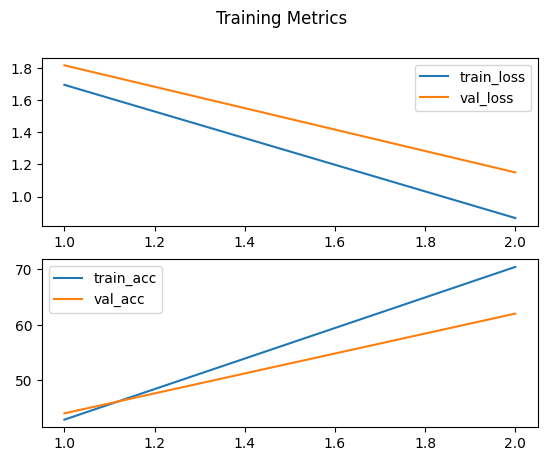

In [54]:
fig, axs = plt.subplots(2)
fig.suptitle('Training Metrics')
axs[0].plot(metrics['train_loss'], label='train_loss')
axs[0].plot(metrics['val_loss'], label='val_loss')
axs[0].legend()

axs[1].plot(metrics['train_acc'], label='train_acc')
axs[1].plot(metrics['val_acc'], label='val_acc')
axs[1].legend()

plt.show()